# SARIMA
This model worked better than the previous. We have tuned it and fitted on data before COVID-19 and checked the difference in the forecast and Actual values for the beginning of the COVID-19 restrictions, adapted from (https://www.kaggle.com/code/sajikim/time-series-forecasting-methods-example-python/notebook)

In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

import itertools
import statsmodels.api as sm

import pandas as pd
import warnings
import matplotlib.pyplot as plt

import numpy as np
np.random.seed(42)

warnings.simplefilter('ignore')

In [2]:
# Import data
combined_states = pd.read_csv(f'../data/combined_states.csv', parse_dates=['week'], index_col='week')
# Get the data for the beginning  of the pandemic
combined_states_covid_2020 = combined_states.loc[:'05-2020']
# Add frequency for forecasting
combined_states_covid_2020 = combined_states_covid_2020.asfreq('W-SUN')
combined_states_covid_2020.tail()

,depression,anxiety,addiction,counselling,mental_health,stay_at_home,mask_mandate,gatherings_banned,business_closures,travel_restrictions
week,,,,,,,,,,
2020-05-03,63.6,61.2,23.9,27.9,38.2,0.7,0.2,0.9,0.9,0.5
2020-05-10,62.7,64.2,23.1,27.4,35.8,0.6,0.3,0.9,0.9,0.5
2020-05-17,57.7,66.6,21.4,29.3,35.7,0.5,0.3,0.9,0.9,0.4
2020-05-24,46.1,67.2,19.3,27.1,33.5,0.4,0.3,0.8,0.8,0.3
2020-05-31,45.6,59.2,20.8,29.7,36.8,0.3,0.3,0.8,0.8,0.3


In [3]:
# adapted from https://towardsdatascience.com/grid-search-for-sarimax-parameters-adbd5104cb8b
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations 
        pdqs : seasonal ARIMA combinations 
        maxiter : number of iterations 
        
    Return:
        Returns dataframe of best five parameter combinations ranked by BIC
    '''
    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, 
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq='W-SUN')

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.bic])
            except:
                continue
            
    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    
    return ans_df

In [3]:
def SARIMA_model(train, test, order, seasonal_order):
    # fit model
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    # make prediction
             
    yhat = model_fit.predict(len(train), len(train) + len(test) - 1)
    res=pd.DataFrame({"pred":yhat, "test":test.values})
    
    # MSE
    print('MSE')
    print(mean_squared_error(res["test"], res['pred']))
    
    return res

## Grid Search best parameters for SARIMA model

In [4]:
# Define the p, d and q parameters to take any value between 0 and 4 (exclusive)
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
  
# list of search term columns
searches_list = ['depression', 'anxiety', 'addiction', 'counselling', 'mental_health']

In [4]:
# Split the data to train - Before COVID-19 Restrictions and Test - the beginning of the restrictions.
df_train = combined_states_covid_2020[:-12]
df_test = combined_states_covid_2020[-12:]
df_train.tail(2)

,depression,anxiety,addiction,counselling,mental_health,stay_at_home,mask_mandate,gatherings_banned,business_closures,travel_restrictions
week,,,,,,,,,,
2020-03-01,63.4,64.4,23.2,38.2,36.4,0.0,0.0,0.0,0.0,0.0
2020-03-08,60.1,63.6,19.7,31.5,29.0,0.0,0.0,0.0,0.0,0.0


In [6]:
for search in searches_list:
    print(f'SARIMAX Best Parameters for {search}')
    print(sarimax_gridsearch(df_train[search], pdq, pdqs))

SARIMAX Best Parameters for depression
           pdq           pdqs         bic
377  (1, 1, 1)  (2, 2, 2, 12)   29.112182
647  (2, 1, 2)  (2, 2, 2, 12)   37.288213
404  (1, 1, 2)  (2, 2, 2, 12)  188.542064
592  (2, 1, 0)  (2, 2, 1, 12)  461.641951
619  (2, 1, 1)  (2, 2, 1, 12)  464.595281
SARIMAX Best Parameters for anxiety
           pdq           pdqs        bic
197  (0, 2, 1)  (0, 2, 2, 12)  16.572539
233  (0, 2, 2)  (1, 2, 2, 12)  24.762806
215  (0, 2, 1)  (2, 2, 2, 12)  24.858808
683  (2, 2, 1)  (0, 2, 2, 12)  24.858808
449  (1, 2, 1)  (1, 2, 2, 12)  24.858808
SARIMAX Best Parameters for addiction
           pdq           pdqs        bic
359  (1, 1, 1)  (0, 2, 2, 12)  20.794415
386  (1, 1, 2)  (0, 2, 2, 12)  24.858808
521  (2, 0, 1)  (0, 2, 2, 12)  25.046324
476  (1, 2, 2)  (1, 2, 2, 12)  28.889941
629  (2, 1, 2)  (0, 2, 2, 12)  29.001943
SARIMAX Best Parameters for counselling
           pdq           pdqs         bic
548  (2, 0, 2)  (0, 2, 2, 12)  165.822045
566  (2, 0, 2)  (2,

For Depression best parameters are (1, 1, 1)  (2, 2, 2, 12), Anxiety (0, 2, 1)  (0, 2, 2, 12), Addiction (1, 1, 1)  (0, 2, 2, 12), Couseling (2, 0, 2)  (0, 2, 2, 12), Mental Health (0, 1, 2)  (1, 2, 2, 12). The worst BIC is for Counseling

## SARIMA 

In [6]:
def sarima_fit_plot(df_train, df_test, order, seasonal_order, search, save = False):
    '''
    Fit and evaluate SARIMA model 
    Input:
    df_train - data frame for training
    df_test - data frame for testing
    order - tuple, order for the model
    seasonal_order - tuple, seasonal order for the model
    search - string, search term
    
    Output:
    MSE
    Plot Avtuas vs Predicted
    '''
    search_str = search.title()
    if search == 'mental_health':
        search_str = 'Mental Health'
    # Get Data for Search
    df_train = df_train[search]
    df_test = df_test[search]
    # Fit the model
    df_ret = SARIMA_model(df_train, df_test, order, seasonal_order)
    #Plot Predictions
    plt.figure(figsize = (10, 6))
    plt.plot(df_ret['pred'], label = 'forecast')
    plt.plot(combined_states_covid_2020.index, combined_states_covid_2020[search], label = 'actual')
    plt.legend()
    plt.title('SARIMA forecasting compared to actual', size=20)
    plt.ylabel(search_str, size=20);
    
    if save == True:
        plt.tight_layout()
        plt.savefig(f'../images/forecasting_sarima_{search}.jpeg');

MSE
74.16592765553705


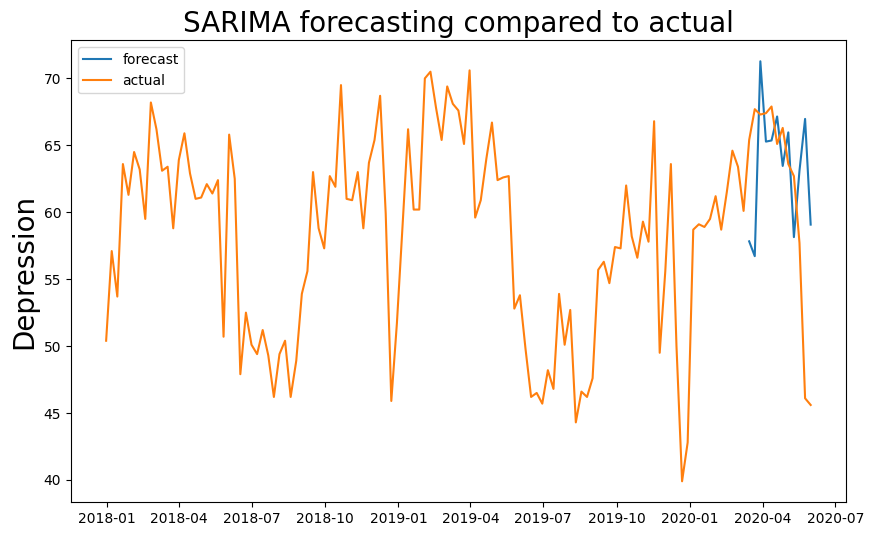

In [7]:
# Plot Depression searches
order = (1, 1, 1)
seasonal_order = (2, 2, 2, 12)
sarima_fit_plot(df_train, df_test, order, seasonal_order, 'depression')

Model predictions are very close to Actual Depression Searches.

MSE
20.633673310419876


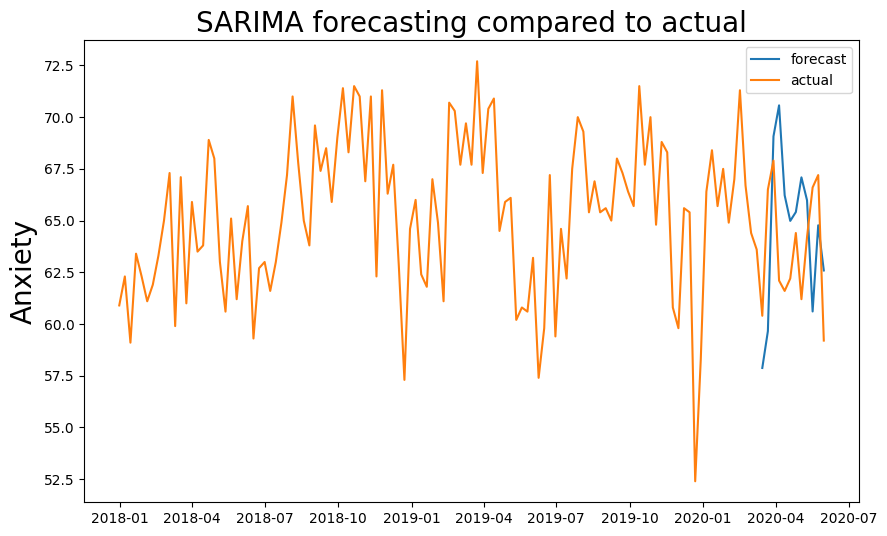

In [29]:
# Plot Anxiety searches
order = (0, 2, 1)
seasonal_order = (0, 2, 2, 12)
sarima_fit_plot(df_train, df_test, order, seasonal_order, 'anxiety')

Anxiety predictions are higher than actual

MSE
6.6713388430191864


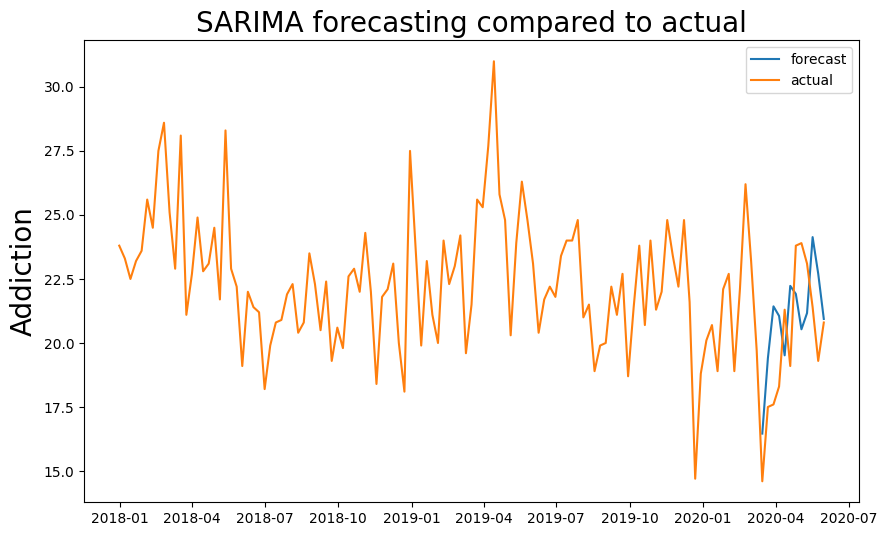

In [30]:
# Plot Addiction searches
order = (1, 1, 1)  
seasonal_order = (0, 2, 2, 12)
sarima_fit_plot(df_train, df_test, order, seasonal_order, 'addiction')

Addiction predictions are spot on.

MSE
136.48108026731467


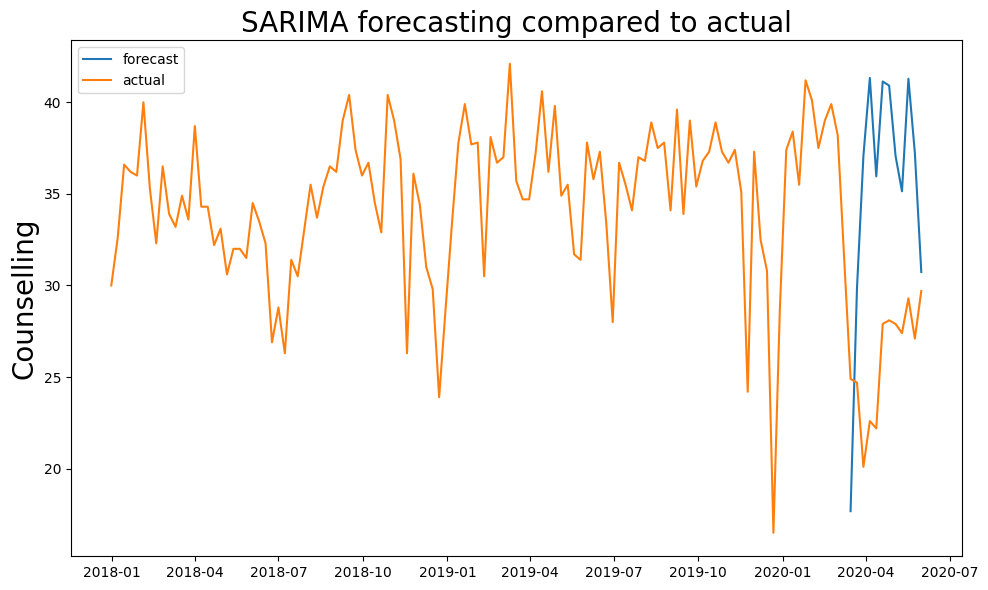

In [8]:
# Plot Counselling searches
order = (2, 0, 2)  
seasonal_order = (0, 2, 2, 12) 
sarima_fit_plot(df_train, df_test, order, seasonal_order, 'counselling', save = True)

Couseling searches are much lower than model predicted

MSE
33.65557062429784


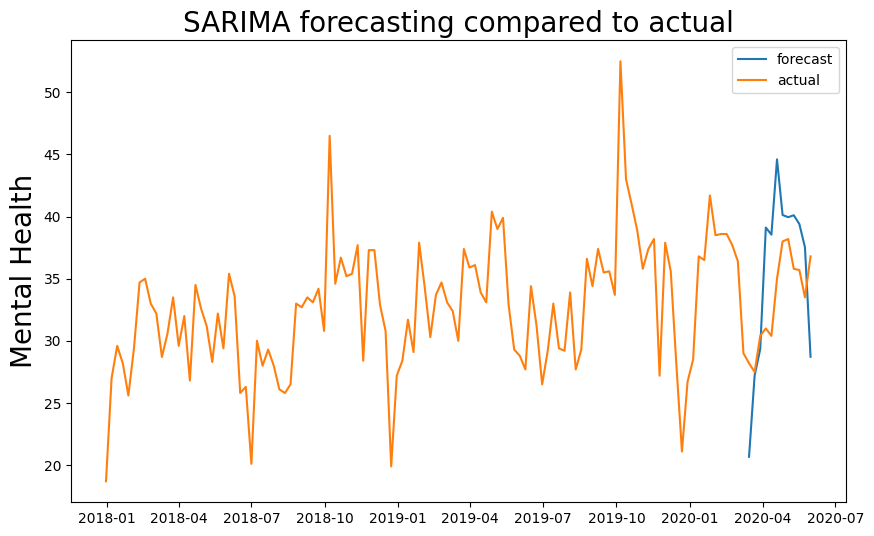

In [32]:
# Plot Mental Health searches
order = (0, 1, 2)   
seasonal_order = (1, 2, 2, 12)
sarima_fit_plot(df_train, df_test, order, seasonal_order, 'mental_health')

Model predicted a bit more Mental Health searches that actual.

---

Conceling is the only forecast that was way off the actual data.